# Fluidinámica computacional

<img src="figures/LogoCinvestav.png" style="height:100px" title="Cinvestav">

**CINVESTAV Unidad Saltillo**

**Programa de Maestría en Ciencias en Ingeniería Metalúrgica**

Dr. Edgar Ivan Castro Cedeño


Enero - Junio 2025

Contacto:
[edgar.castro@cinvestav.mx](mailto:edgar.castro@cinvestav.mx)

In [1]:
using CSV
using DataFrames
using Plots
using LaTeXStrings
using Integrals

# Tarea

## 1. Curvas RTD

Utilizando los resultados de simulación, trace las curvas $F$ vs $\theta$, y $C$ vs $\theta$ correspondientes.

- Calcule las variables adimensionales requeridas, $\theta$, $F$, y $C$.

- Trace las curvas $F$ vs $\theta$, y $C$ vs $\theta$ correspondientes.

- Comente sobre las curvas, comparando su comportamiento contra las curvas para flujo en reactores idealizados que se muestran debajo. 

<center>

<img src="figures/images/idealFCurves.png" style="width:400px" title="F vs theta">

***Figura 01. Curvas F para flujo en reactores idealizados.***

</center>

<center>

<img src="figures/images/idealCCurves.png" style="width:400px" title="C vs theta">

***Figura 02. Curvas C para flujo en reactores idealizados.***

</center>

## Respuesta:

### Leer datos de concentración de trazador

In [2]:
# load data of tracer concentration 
path = "figures/openFoam/scalarValueAtOutlet.dat"
df = CSV.read(path, DataFrame, header=5, )

# modify the column names so they are more "friendly"
println("previous column names: $(names(df))")
rename!(df,:"# Time          " => :t)
rename!(df,:"areaAverage(T)" => :c)
println("new column names: $(names(df))")

previous column names: ["# Time          ", "areaAverage(T)"]
new column names: ["t", "c"]


### Estimación de variables adimensionales

#### tiempo, $\theta$

In [3]:
# add a column with dimensionless time (theta)
tr = 280.0 # theoretical residence time, [s]
df.θ = df.t / tr;

#### concentración, $F$

In [4]:
# add column with dimensionless concentration F
cᵢ = 1 # tracer concentration at entrance
df.F = df.c / cᵢ;

#### concentración, $C$

In [5]:
## Estimation of gradients with different implementations

"""
backwardDiff
"""
function backwardDiff(x, y)
    grads = zeros(size(x))
    for i in 1:length(grads)
        if i == 1
            grads[i] = (y[i+1] - y[i]) / (x[i+1] - x[i])
        else
            grads[i] = (y[i] - y[i-1]) / (x[i] - x[i-1])
        end
    end
    return grads
end

"""
forwardDiff
"""
function forwardDiff(x, y)
    grads = zeros(size(x))
    for i in 1:length(grads)
        if i == length(grads)
            grads[i] = (y[i] - y[i-1]) / (x[i] - x[i-1])
        else
            grads[i] = (y[i+1] - y[i]) / (x[i+1] - x[i])
        end
    end
    return grads
end

"""
centralDiff
"""
function centralDiff(x, y)
    grads = zeros(size(x))
    for i in 1:length(grads)
        if i == 1
            grads[i] = (y[i+1] - y[i]) / (x[i+1] - x[i])
        elseif i == length(grads)
            grads[i] = (y[i] - y[i-1]) / (x[i] - x[i-1])
        else
            grads[i] = (y[i+1] - y[i-1]) / (x[i+1] - x[i-1])
        end
    end
    return grads
end

centralDiff

In [6]:
# add column with dimensionless concentration C
#df.C = backwardDiff(df.θ, df.F);
#df.C = forwardDiff(df.θ, df.F);
df.C = centralDiff(df.θ, df.F);

### Gráficos con comentarios

#### Curva $F$ vs $\theta$

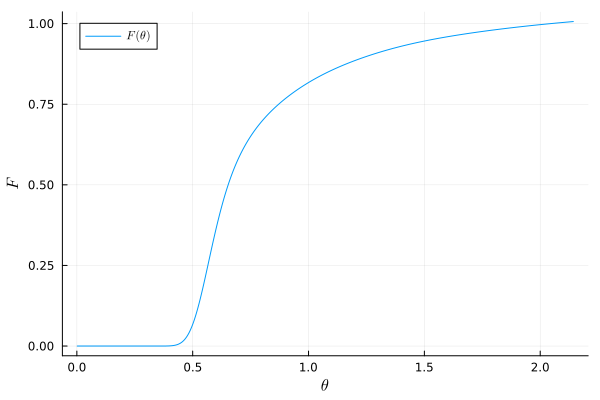

In [7]:
plot(df.θ, df.F, label=L"F(\theta)")
xlabel!(L"$\theta$")
ylabel!(L"F")

Al comparar la curva $F(\theta)$ contra los casos idealizados de flujo pistón y flujo en un reactor perfectamente agitado se tiene que:

- La curva comienza a crecer hasta que cierto tiempo de latencia (en este caso $\theta \approx 0.5$) ha transcurrido. Esta característica se comparte con el flujo pistón.

- Después del crecimiento "subito" de la curva, la curva exhibe un crecimiento hacia un valor asintótico de uno. Esta característica se comparte con el flujo perfectamente agitado.

#### Curva $C$ vs $\theta$

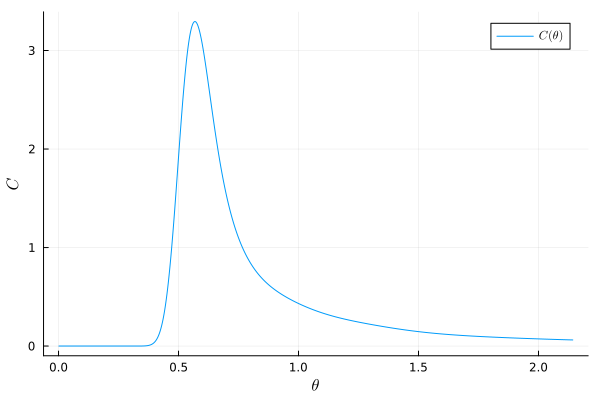

In [8]:
plot(df.θ, df.C, label=L"C(\theta)")
xlabel!(L"$\theta$")
ylabel!(L"C")

Al comparar la curva $C(\theta)$ contra los casos idealizados de flujo pistón y flujo en un reactor perfectamente agitado se tiene que:

- La curva comienza a crecer hasta que cierto tiempo de latencia (en este caso $\theta \approx 0.5$) ha transcurrido. Esta característica se comparte con el flujo pistón.

- Después del crecimiento "subito" de la curva, la curva exhibe una disminuación hacia el valor asintótico de cero. Esta característica se comparte con el flujo perfectamente agitado.

## 2. Fracciones volumétricas de zonas en el reactor

El análisis de curvas RTD permite realizar una evaluación global de la "repartición" de distintas zonas de flujo en el volumen del reactor

$$
V_{dp} + V_{m} + V_{d} = \bar{V}
$$


<details>
<summary><b>Nomenclatura</b></summary>

<div class="alert alert-info">

**$V_{dp}$**: volumen de zona con flujo pistón disperso, en $[\mathrm{m^3}]$.

**$V_{m}$**: volumen de zona con flujo mixto, en $[\mathrm{m^3}]$.

**$V_{d}$**: volumen de zona con flujo muerto, en $[\mathrm{m^3}]$.

**$\bar{V}$**: volumen total del reactor, en $[\mathrm{m^3}]$.

</div>

</details>

Utilizando las siguientes ecuaciones se puede estimar la contribución de cada una de las zonas:

$$
\frac{V_{dp}}{\bar{V}} = \frac{\theta_{min} + \theta_{max}}{2}
$$

$$
\frac{V_d}{\bar{V}} = 1 - \left[\sum_{\theta=0}^{\theta=2} C(\theta)\,\Delta\theta \right] \cdot \bar{\theta}
$$

$$
\frac{V_m}{V} = 1 - \frac{V_{dp}}{V} - \frac{V_{d}}{V}
$$

Para utilizar las ecuaciones presentadas arriba, se requiere tener conocimiento de la curva $C(\theta)$ y de los tiempos característicos del reactor, que se muestran en la tabla debajo:

<center>

| nombre | definición |
|--------|------------|
| tiempo de residencia teórico | $t_r = \frac{\bar{V}}{\dot{v}}$ |
| tiempo de residencia (adimensional) | $\theta = \frac{t}{t_r}$ |
| tiempo de residencia promedio (adimensional) | $\bar{\theta} = \frac{\int_0^{2\theta} \theta C(\theta) d\theta}{\int_0^{2\theta} C(\theta) d\theta}$ |
| tiempo de residencia mínimo (adimensional) | $\theta_{min}$ |
| tiempo de residencia máximo (adimensional) | $\theta_{max}$ |

</center>

Con los resultados del Análisis RTD de los resultados de simulación, estime la repartición de distintas zonas en el reactor.

# Respuesta

### tiempos de interés

**tiempo de residencia teórico:**

In [9]:
V = 3.5 * 0.8 * 0.1 # volumen del reactor, [m3]
v = 0.1 * 0.1 * 0.1 # flujo volumétrico en el reactor, [m3.s-1]
tr = V/v
println("tᵣ = $(round(tr, digits=2)) [s]")

tᵣ = 280.0 [s]


In [10]:
df[1120, :t] # index in dataframe where t= 2 tr.
twoThetaThreshold = 2*tr
twoThetaIndex = findfirst(x -> x >= (twoThetaThreshold), df.t)
println("2tᵣ = $(round(df.t[twoThetaIndex], digits=2)) [s]")
println("index: $(twoThetaIndex)")

2tᵣ = 560.0 [s]
index: 1120


**tiempo de residencia (adimensional):**

In [11]:
θ = df.θ[1:twoThetaIndex]; # dimless residence time
C = df.C[1:twoThetaIndex]; # dimless concentration
println("theta: $(θ)")

theta: [0.0017857142857142857, 0.0035714285714285713, 0.005357142857142857, 0.007142857142857143, 0.008928571428571428, 0.010714285714285714, 0.0125, 0.014285714285714285, 0.01607142857142857, 0.017857142857142856, 0.019642857142857142, 0.02142857142857143, 0.023214285714285715, 0.025, 0.026785714285714284, 0.02857142857142857, 0.030357142857142857, 0.03214285714285714, 0.033928571428571426, 0.03571428571428571, 0.0375, 0.039285714285714285, 0.04107142857142857, 0.04285714285714286, 0.044642857142857144, 0.04642857142857143, 0.048214285714285716, 0.05, 0.05178571428571429, 0.05357142857142857, 0.055357142857142855, 0.05714285714285714, 0.05892857142857143, 0.060714285714285714, 0.0625, 0.06428571428571428, 0.06607142857142857, 0.06785714285714285, 0.06964285714285715, 0.07142857142857142, 0.07321428571428572, 0.075, 0.07678571428571429, 0.07857142857142857, 0.08035714285714286, 0.08214285714285714, 0.08392857142857142, 0.08571428571428572, 0.0875, 0.08928571428571429, 0.091071428571428

**tiempo de residencia promedio (adimensional):**


In [12]:
# numerador
y = @. θ * C
x = θ
problem = SampledIntegralProblem(y, x)
method = TrapezoidalRule()
num = solve(problem, method)

# denominador
y = C
x = θ
problem = SampledIntegralProblem(y, x)
method = TrapezoidalRule()
den = solve(problem, method)

# tiempo de residencia promedio
θavg = num.u / den.u
println("̄θ = $(round(θavg, digits=4))")

̄θ = 0.7739


**tiempo de residencia mínimo (adimensional):**

In [13]:
minThreshold = 1e-1
minIndex = findfirst(x -> x > (minThreshold), C)
θmin = θ[minIndex]
println("θ(min) = $(round(θmin, digits=4))")
println("index: $(minIndex)")

θ(min) = 0.4161
index: 233


**tiempo de residencia máximo (adimensional):**

In [14]:
Cmax, maxIndex = findmax(C)
θmax = θ[maxIndex] 
println("θ(max) = $(round(θmax, digits=4))")
println("C(max) = $(round(Cmax, digits=4))")
println("index: $(maxIndex)")

θ(max) = 0.5679
C(max) = 3.294
index: 318


### Estimación de fracciones volumétricas del reactor

**Zona con flujo pistón disperso:**

In [15]:
V = 3.5 * 0.8 * 0.1 # volumen del reactor, [m3]
Vdp_V = 0.5 * (θmin + θmax);

**Zona con flujo muerto:**

In [16]:
Δθ = forwardDiff(collect(1:1:length(θ)), θ);
Vd_V = 1 - (sum(@. (C * Δθ))) * θavg;

**Zona con flujo mixto:**

In [17]:
Vm_V = 1 - Vdp_V - Vd_V;

**Repartición de zonas:**

In [18]:
println("REPARTICION VOLUMETRICA DE ZONAS:")
println("pistón disperso: $(round(Vdp_V, digits=4))")
println("flujo mixto    : $(round(Vm_V, digits=4))")
println("zonas muertas  : $(round(Vd_V, digits=4))")

REPARTICION VOLUMETRICA DE ZONAS:
pistón disperso: 0.492
flujo mixto    : 0.2796
zonas muertas  : 0.2285
